In [5]:
import json
import sys
sys.path.append('../py')
import myutils as my
import importlib
importlib.reload(my)
import json
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from matplotlib.gridspec import GridSpec
from matplotlib import ticker

# plt.rcParams["font.family"] = "serif"
# plt.rcParams["mathtext.fontset"] = "dejavuserif"

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{xcolor}'

from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)


pgf_with_latex = {
    "text.usetex": True,            # use LaTeX to write all text
    "pgf.rcfonts": False,           # Ignore Matplotlibrc
    "pgf.preamble": 
        r'\usepackage{xcolor}'     # xcolor for colours
    
}
matplotlib.rcParams.update(pgf_with_latex)

matplotlib.rcParams['agg.path.chunksize'] = 10000

recalculate = recompile = True

def set_ticks(ax_all, N=6, cut_x = 0.15, cut_y = 0.2):
    for ax in ax_all:
        ax.tick_params(axis='both', labelsize=6)
        ax.margins(x=0.)

        box = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        box_w = box.width
        box_h = box.height

        if ax.get_xscale() == "log":
            ax.xaxis.set_major_locator(ticker.LogLocator(numticks=N))
        else:
            ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=N))

        if ax.get_yscale() == "log":
            ax.yaxis.set_major_locator(ticker.LogLocator(numticks=N))
            ax.yaxis.set_minor_locator(ticker.LogLocator(subs="auto", numticks=10))
        else:
            ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=N))

        (x0, x1) = ax.get_xlim()
        (y0, y1) = ax.get_ylim()


        x0 = ax.dataLim.x0
        x1 = ax.dataLim.x1
        y0 = ax.dataLim.y0
        y1 = ax.dataLim.y1



        axis_to_data = ax.transAxes + ax.transData.inverted()
        (x2, y2) = axis_to_data.transform([1 - cut_x/box.width, 1 - cut_y/box.height])
        (x0, y0) = axis_to_data.transform([-0.1, -0.1])

        # print(x0, x1, x2)
        # print(y0, y1, y2)


        ax.set_xticks([tick for tick in ax.get_xticks() if tick <= x2])
        ax.set_yticks([tick for tick in ax.get_yticks() if tick >= y0 and tick <= y2])

        # print(ax.get_yticklabels())

        if ax.get_yscale() == "log":       
            ax.set_yticklabels([label.get_text().replace("-", "\\mbox{-}") for label in ax.get_yticklabels()])
        # print(ax.get_yticklabels())

def set_labels(ax, x_label, y_label):
    box = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    
    if x_label:
        ax.text(1, -0.05/box.height, x_label, transform=ax.transAxes, va="top", ha="right")
    if y_label:
        ax.text(-0.03/box.width, 1,  y_label, transform=ax.transAxes, va="top", ha="right")

{'alpha': 1, 'xi': 0.5, 'n': 5, 'beta': 0.05, 'eta': 2.5, 'ts': 2.0, 'Ts': 4.0, 'd': 1.5, 'l1': 1.0, 'h': 20.5, 'integration_step': 0.01, 'integration_finish': 50, 'lambda': 50}
~~~ ../cpp/default.cpp is executed ~~~
1
20.5
~~~ Computation took 0:0:0 (hh:mm:ss) ~~~
~~~ ../cpp/default.cpp is finished ~~~


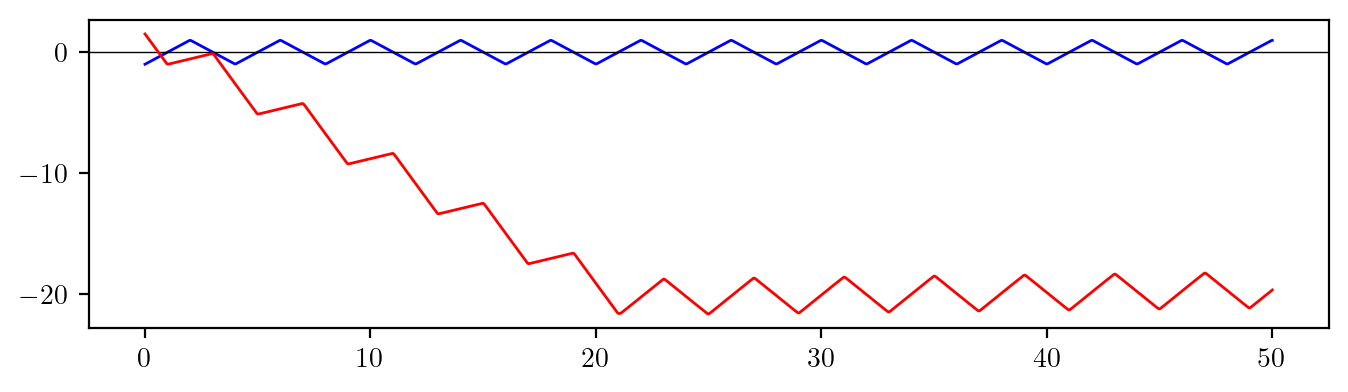

In [121]:
alpha=1;
beta=0.05
xi=0.5
n=5
lambda_=50
# beta = (1+xi)/(n*(1+alpha)) - 1 + 0.921
eta = 1+ (1+xi)/alpha
ts = 1 + 1/alpha
Ts = 2 + alpha + 1/alpha
d = 0.5*(1+xi)*ts
l1 = d/(1+xi)
h = n * Ts + l1/2
Tk = 200*Ts;

params = dict(
    alpha=alpha,
    xi=xi,
    n=n,
    beta=beta,
    eta=eta,
    ts=ts,
    Ts=Ts,
    d=d,
    l1=l1,
    h=h,
    integration_step=0.01,
    integration_finish=50
)
params["lambda"] = lambda_

print(params)

compiler_params = dict(
    EQ = "ResurgentNeuron",
    RK = "RK98_",
    REAL = "float64",
    # RETURN = "ReturnSolution()",
    RETURN = "ReturnSolutionWithDelays(de.f_spec)",
    INIT_FUNCTION = "ConstantVecMapC<2>({-1.," + f"{d}" + "})",
)

script = "default"

recompile=True
# recompile=False
        
t, X = my.run_cpp(script, params, compiler_params, recalculate=recalculate, recompile=recompile, flags = "-O3")    

x, y, x_1, y_1, x_h, y_h = X.T

# print(X.shape)

fig, ax = plt.subplots(1,1, figsize=(8,2),dpi=200)

ax.plot(t, x, lw=1,c='b')
# ax.plot(t, x_1, lw=1,c='b', linestyle="--")
# ax.plot(t, x_h, lw=0.5,c='k')

ax.axhline(y=0, c='k', lw=0.5)

ax.plot(t, y, lw=1,c='r')
# ax.plot(ts2, xs2,lw=1,c='k')


# ax.plot(ts, true_xs,lw=3,c='g')
# ax.plot(ts, xs, lw=1,c='k')
# ax.plot(ts2, xs2, lw=1,c='k')
# ax.plot(ts + 2*params["T"], xs, lw=1)
# ax.margins(x=0)

# ax.set_ylabel(r"$x(t)$, \textcolor{red}{$x_*(t)$}", rotation=0,labelpad=20,y=0.5, va='center')

# plt.savefig(f"../output/{script.replace('/', '::')} {compiler_params} {params}.pdf".replace('{', "").replace('}', ""), format="pdf", dpi=1000,bbox_inches='tight',pad_inches=0.01,transparent=True,backend='pgf')

